## Motif Detection
### Stellina Ao, 10.13.2024 - 
The purpose of this code is to detect hippocampal motifs in data collected by the Allen Institute.

#### Read in Data

In [1]:
from pynwb import NWBHDF5IO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

import warnings
warnings.filterwarnings("ignore")

In [2]:
io = NWBHDF5IO('..\..\..\Data\sub-692072_ses-1298465622.nwb', mode="r", load_namespaces=True)
nwb = io.read()
units_raw = nwb.units
col_names = list(units_raw[0])
electrodes = nwb.electrodes
#where(nwb.electrodes['location'][:] == 'CA1')

In [84]:
trials_raw = nwb.behavior
type(trials_raw)

AttributeError: 'NWBFile' object has no attribute 'behavior'

Isolate CA1

In [3]:
units = []

for i in range(len(units_raw)):
    peak_id = units_raw.peak_channel_id[i] # unit id --> electrode id
    location_id = np.where(electrodes.id[:]==peak_id)[0] # electrode id --> location index
    location_name = str(electrodes['location'][location_id])[2:-2] # location index --> location name

    if location_name == "CA1":
        units_i = units_raw[i].values.tolist()[0]
        units.append(units_i)
    

In [4]:
units = pd.DataFrame(units, columns=col_names)
units

,recovery_slope,presence_ratio,velocity_above,snr,nn_hit_rate,amplitude,amplitude_cutoff,cluster_id,waveform_duration,max_drift,...,quality,nn_miss_rate,spread,PT_ratio,firing_rate,l_ratio,silhouette_score,spike_times,spike_amplitudes,waveform_mean
0,-1.000000,0.99,-0.103015,0.416924,0.270882,67.121145,0.500000,171,1.634506,31.44,...,noise,0.022598,140.0,4.849517,2.255217,0.231291,0.096603,"[22.78182278016842, 22.807422693593516, 23.131...","[3.922582485302846e-05, 3.670163308088668e-05,...","[[0.0, -0.6314099999999974, -1.365974999999999..."
1,-0.532755,0.99,0.011446,0.703193,0.513333,59.689110,0.500000,172,2.046566,18.74,...,noise,0.033796,170.0,0.299286,5.813922,0.236176,-0.001593,"[21.57582685865791, 22.122425010148493, 22.285...","[6.217149405793323e-05, 5.594412400168287e-05,...","[[0.0, -0.5879249999999985, -1.37358, -1.10701..."
2,-0.038140,0.99,0.892797,1.114907,0.994000,93.104505,0.020325,173,0.494472,23.03,...,good,0.000368,120.0,0.381165,3.407846,0.000540,0.122963,"[31.857492087674977, 32.26179072040027, 37.170...","[0.0001111246902649, 8.990657825610332e-05, 0....","[[0.0, -0.4369950000000018, -0.979875000000006..."
3,-0.043289,0.99,0.343384,1.156439,0.946667,72.605130,0.452410,174,0.302178,18.61,...,good,0.044405,100.0,0.477054,12.240420,0.030185,0.071006,"[20.524197081771923, 20.6163634367464, 21.1379...","[8.397554213019525e-05, 6.347096966217724e-05,...","[[0.0, 0.9455549999999984, 1.7785949999999986,..."
4,-0.074747,0.99,-0.091569,0.969209,0.923333,59.180745,0.377369,175,0.302178,26.51,...,noise,0.048877,150.0,0.625579,17.362320,0.022455,0.060853,"[20.71629643212198, 20.788929519821576, 20.857...","[8.578274397045404e-05, 6.511100066774274e-05,...","[[0.0, -0.9594000000000021, -0.980850000000002..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,-0.028849,0.17,-0.022892,1.238933,0.000000,94.625289,0.000681,608,0.727973,6.42,...,good,0.000033,120.0,0.223661,0.046950,0.001384,-1.000000,"[3615.9006047480316, 3630.016157011443, 3633.3...","[0.0002137390130016982, 0.0004633663177824609,...","[[0.0, -0.5983421052631572, -0.554210526315789..."
158,-0.131547,0.55,0.902608,4.151433,0.333333,217.681379,0.004751,609,0.631826,17.04,...,good,0.000267,70.0,0.431843,0.044356,0.011598,0.060925,"[2421.2780447745954, 2427.3413576027533, 2457....","[0.00010851743409720796, 0.0001047824361180276...","[[0.0, 0.2743036211699168, -0.3117827298050144..."
159,-0.081595,0.82,0.882986,3.032849,0.611111,172.240925,0.223263,614,0.631826,24.88,...,good,0.000467,70.0,0.376840,0.098225,0.005979,-1.000000,"[587.0735144339675, 647.3613772165161, 743.605...","[0.00027037865676346137, 0.0002511933876652157...","[[0.0, 0.05641509433962488, -0.431943396226415..."
160,-0.111812,0.76,0.274707,3.683995,0.400000,336.955674,0.027993,621,0.686767,24.14,...,good,0.000300,60.0,0.277311,0.077962,0.000147,-1.000000,"[36.3437769157617, 36.403476713866326, 36.5770...","[0.00032542453922756976, 0.0003056701614838182...","[[0.0, -1.0179556259904938, -1.368708399366088..."


In [5]:
unitSpikeTimes_raw = units["spike_times"]
print(np.shape(unitSpikeTimes_raw))
unitSpikeTimes_raw[0]

(162,)


array([  22.78182278,   22.80742269,   23.1314216 , ..., 8113.99835955,
       8114.12842578, 8114.162459  ])

#### Convert Spike Times to Spike Trains

In [6]:
unitSpikeTimes = [np.round(unitSpikeTimes_raw[i], 3) for i in range(len(unitSpikeTimes_raw))] # seconds
unitSpikeTimes[0]

array([  22.782,   22.807,   23.131, ..., 8113.998, 8114.128, 8114.162])

In [7]:
unitSpikeTimes_whole = [np.unique([int(unitSpikeTimes[i][j] * 1e3) for j in range(len(unitSpikeTimes[i]))]) for i in range(len(unitSpikeTimes))] # ms
unitSpikeTimes_whole[0]

array([  22782,   22807,   23131, ..., 8113998, 8114128, 8114162])

NOTE: now, 1 s = 1000 indices; 1 ms = 1e-3 s = 1 index

In [8]:
spikeTrains = []
for i in range(3):
    print(i)
    spikeTimes = unitSpikeTimes_whole[i]
    length = int(spikeTimes[len(spikeTimes)-1])
    
    spikeTrains_i = np.zeros(length)
    k = 0

    for j in range(length):
        if spikeTimes[k] == j:
            spikeTrains_i[j] = 1
            k+=1

    spikeTrains.append(spikeTrains_i)
        

0
1
2


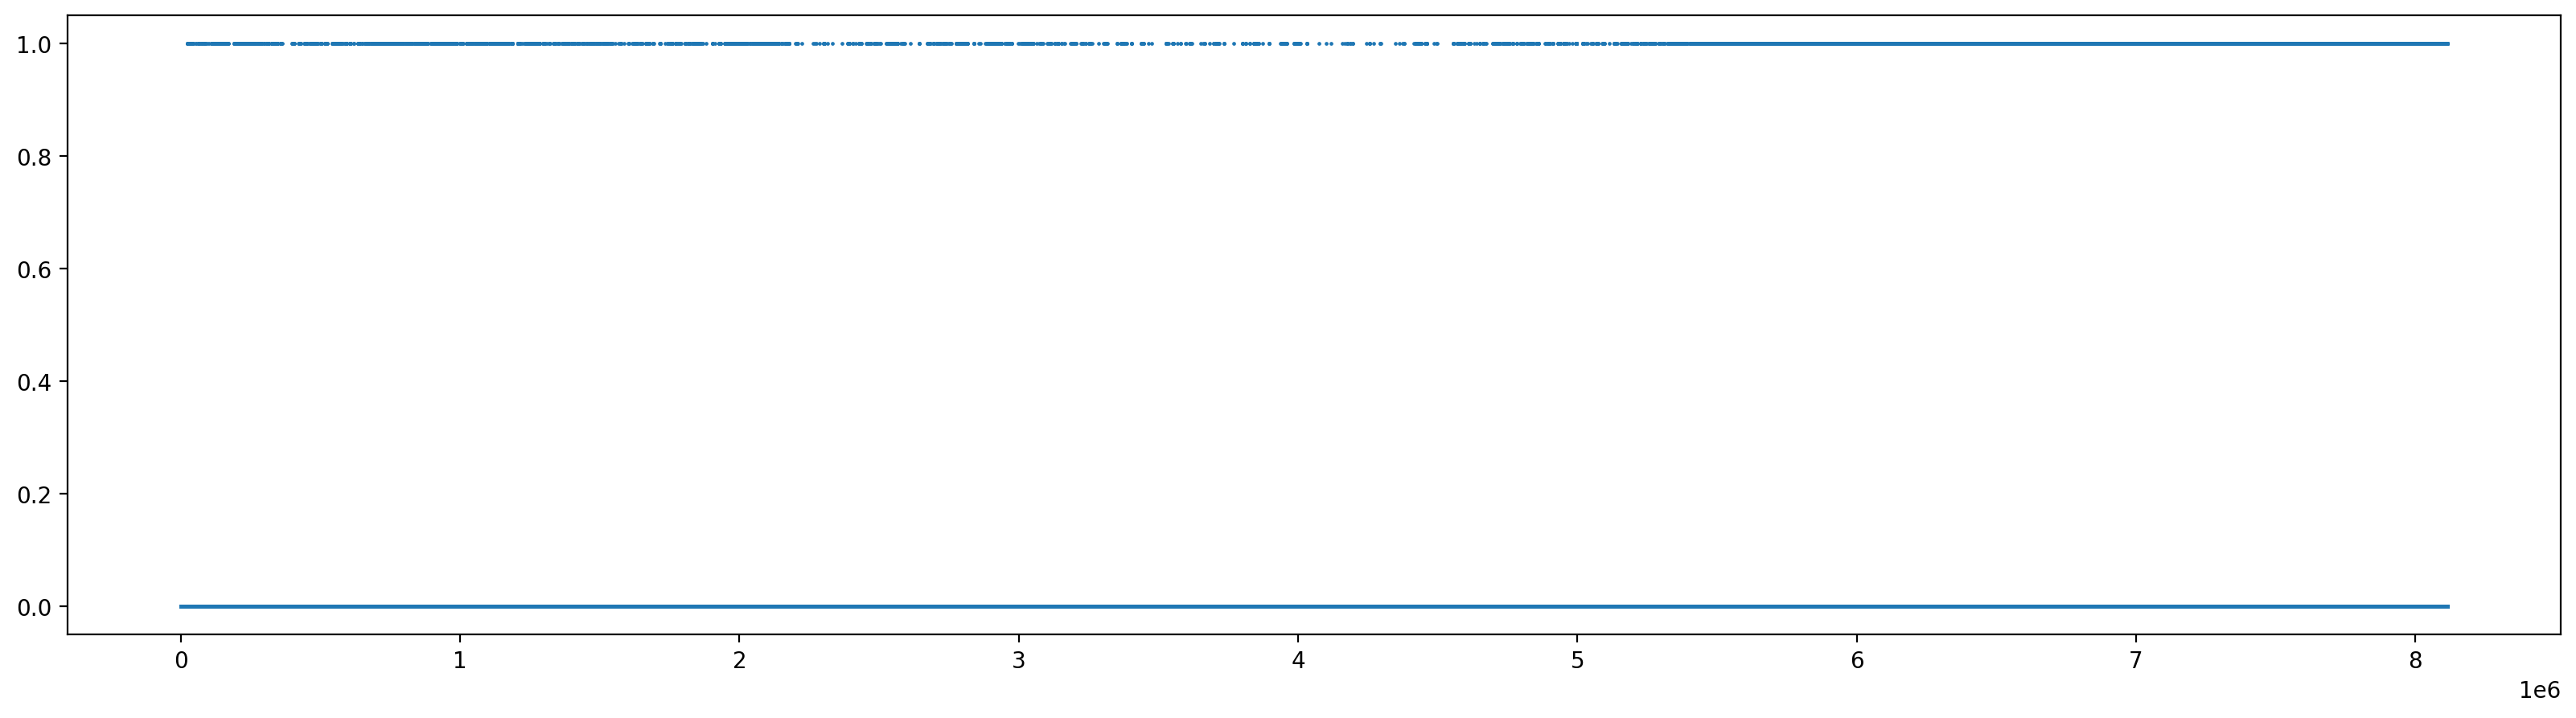

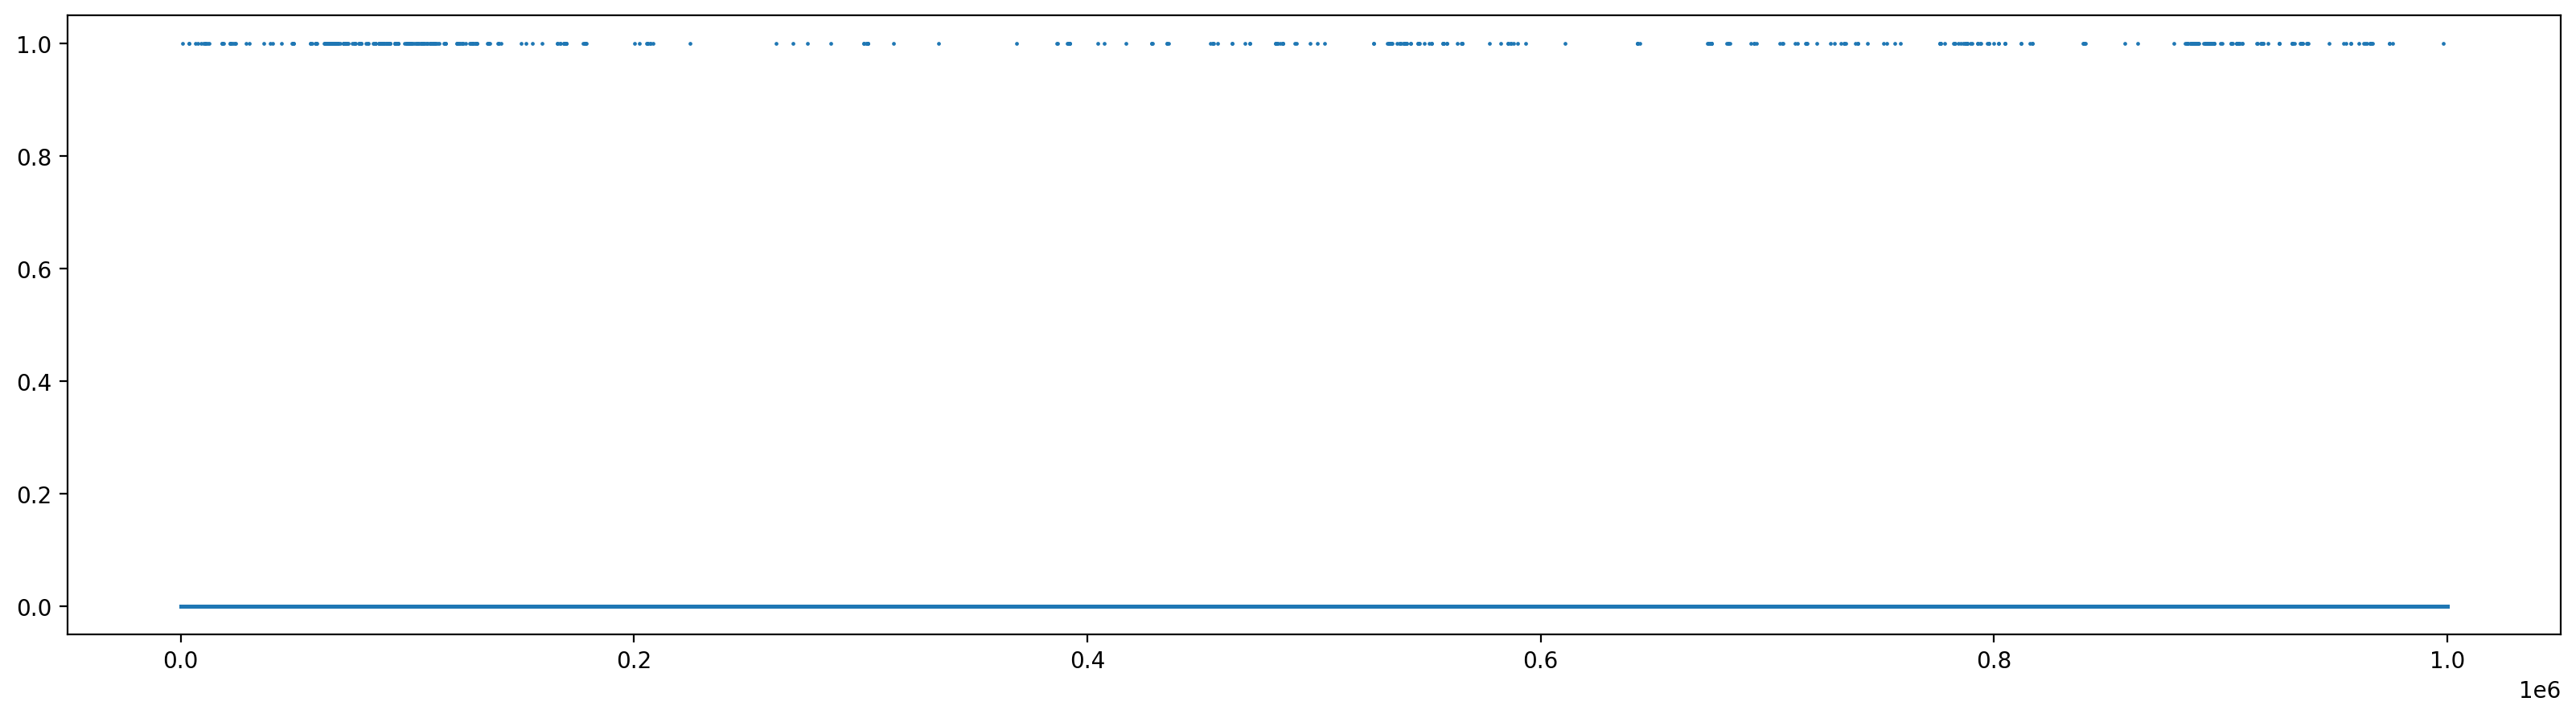

In [9]:
plt.figure(figsize=(20, 5), dpi = 200)
plt.scatter(range(len(spikeTrains[0])), spikeTrains[0], s=0.5)
plt.figure(figsize=(20, 5), dpi = 200)
plt.scatter(range(len(spikeTrains[0][2000000:3000000])), spikeTrains[0][2000000:3000000], s=0.5)

#### Motif Detection

In [10]:
def peakFR(spikeTrain, windowSize = 1000): # NOTE: 1 index = 1 ms np.convolve   window = 1000 # 1000 indices = 1 s
    kernel=list(np.zeros(0)) + list(np.ones(windowSize)) + list(np.zeros(0))
    
    cST = list(np.convolve(spikeTrain, kernel))

    peakFR = max(cST)
    indexE = cST.index(max(cST)) + 1
    indexS = indexE - 1000 if indexE - 1000 >= 0 else 0
    
    return peakFR, (indexS, indexE)

def minFR(spikeTrain, windowSize = 1000):
    kernel=list(np.zeros(0)) + list(np.ones(windowSize)) + list(np.zeros(0))

    print(np.shape(spikeTrain))
    
    cST = list(np.convolve(spikeTrain, kernel, "same"))
    
    minFR = min(cST)
    indexE = cST.index(min(cST)) + 1
    indexS = indexE - 1000 if indexE - 1000 >= 0 else 0
    
    return minFR, (indexS, indexE)

In [11]:
def isMotif(spikeTrain):
    # conditions to be a motif:
    #     neuron achieved a peak firing rate of at least 5 Hz (5 spike/1000 indices) and 
    #     maintained a firing rate above 10% of that peak for at least 300 ms
    
    pfr, pfrIndices = peakFR(spikeTrain[0:-300])
    print(f"pfrIndices: {pfrIndices}; np.shape(spikeTrain): {np.shape(spikeTrain)}")
    mfr, mfrIndices = minFR(spikeTrain[pfrIndices[1]:pfrIndices[1]+300])

    print(f"pfr: {pfr}; mfr: {mfr}; mfrI: {mfrIndices}")

    if pfr >= 5 and mfr > 0.1*pfr:
        return True
    
    return False

In [12]:
def findMotifs(spikeTrain): # 
    motifIndices = []
    binLen = 2 * 1000 # 10 seconds

    for i in range(len(spikeTrain)//binLen):
        start = i * binLen
        end = (i+1)*binLen if i!=len(spikeTrain)//binLen else len(spikeTrain)+1
        
        stBin = spikeTrain[start:end]

        if isMotif(stBin):
            motifIndices.append((start, end))

    return motifIndices

In [13]:
findMotifs(spikeTrains[0])

pfrIndices: (0, 1); np.shape(spikeTrain): (2000,)
(300,)
pfr: 0.0; mfr: 0.0; mfrI: (0, 1)
pfrIndices: (0, 1); np.shape(spikeTrain): (2000,)
(300,)
pfr: 0.0; mfr: 0.0; mfrI: (0, 1)
pfrIndices: (0, 1); np.shape(spikeTrain): (2000,)
(300,)
pfr: 0.0; mfr: 0.0; mfrI: (0, 1)
pfrIndices: (0, 1); np.shape(spikeTrain): (2000,)
(300,)
pfr: 0.0; mfr: 0.0; mfrI: (0, 1)
pfrIndices: (0, 1); np.shape(spikeTrain): (2000,)
(300,)
pfr: 0.0; mfr: 0.0; mfrI: (0, 1)
pfrIndices: (0, 1); np.shape(spikeTrain): (2000,)
(300,)
pfr: 0.0; mfr: 0.0; mfrI: (0, 1)
pfrIndices: (0, 1); np.shape(spikeTrain): (2000,)
(300,)
pfr: 0.0; mfr: 0.0; mfrI: (0, 1)
pfrIndices: (0, 1); np.shape(spikeTrain): (2000,)
(300,)
pfr: 0.0; mfr: 0.0; mfrI: (0, 1)
pfrIndices: (0, 1); np.shape(spikeTrain): (2000,)
(300,)
pfr: 0.0; mfr: 0.0; mfrI: (0, 1)
pfrIndices: (0, 1); np.shape(spikeTrain): (2000,)
(300,)
pfr: 0.0; mfr: 0.0; mfrI: (0, 1)
pfrIndices: (0, 1); np.shape(spikeTrain): (2000,)
(300,)
pfr: 0.0; mfr: 0.0; mfrI: (0, 1)
pfrIndices

[(126000, 128000),
 (2894000, 2896000),
 (4422000, 4424000),
 (4718000, 4720000),
 (4994000, 4996000),
 (5342000, 5344000),
 (5436000, 5438000),
 (5522000, 5524000),
 (5526000, 5528000),
 (5530000, 5532000),
 (5678000, 5680000),
 (5904000, 5906000),
 (6072000, 6074000),
 (6196000, 6198000),
 (6360000, 6362000),
 (6440000, 6442000),
 (6722000, 6724000),
 (6748000, 6750000),
 (6800000, 6802000),
 (6906000, 6908000),
 (6912000, 6914000),
 (6928000, 6930000),
 (7014000, 7016000),
 (7032000, 7034000),
 (7040000, 7042000),
 (7086000, 7088000),
 (7134000, 7136000),
 (7170000, 7172000),
 (7182000, 7184000),
 (7188000, 7190000),
 (7212000, 7214000),
 (7252000, 7254000),
 (7254000, 7256000),
 (7268000, 7270000),
 (7328000, 7330000),
 (7358000, 7360000),
 (7390000, 7392000),
 (7422000, 7424000),
 (7574000, 7576000),
 (7594000, 7596000),
 (7600000, 7602000),
 (7724000, 7726000),
 (7822000, 7824000),
 (7914000, 7916000),
 (7998000, 8000000)]

### Plot kymographs of motifs

In [60]:
# kymograph: x-axis is position, y-axis is time
plt.scatter(location , unitSpikeTimes[0])

### Poisson Surprise

In [41]:
mfr_ms = sum(spikeTrains[0])/len(spikeTrains[0]) # avg num of spikes per ms
isi_ms = np.diff(unitSpikeTimes_whole[0])
isi_ms_10 = [x for x in isi_ms if x <= 10]

poissonSim_ms = np.random.poisson(mfr_ms, (len(isi_ms),))
ks_2samp(isi_ms, poissonSim_ms)

KstestResult(statistic=0.9984006176924773, pvalue=0.0, statistic_location=0, statistic_sign=-1)

Text(0.5, 1.0, 'Poisson Distribution (lambda = avg # spikes / ms)')

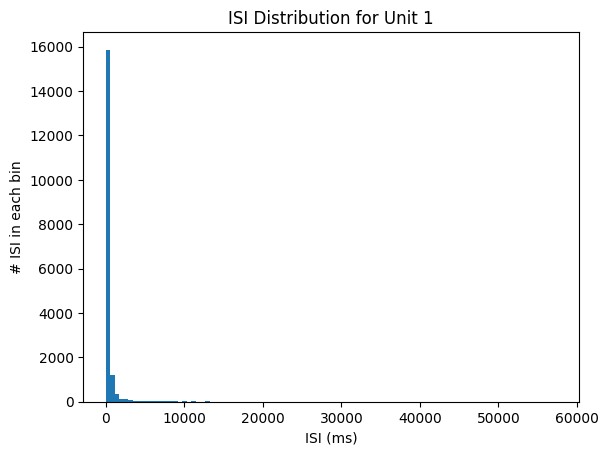

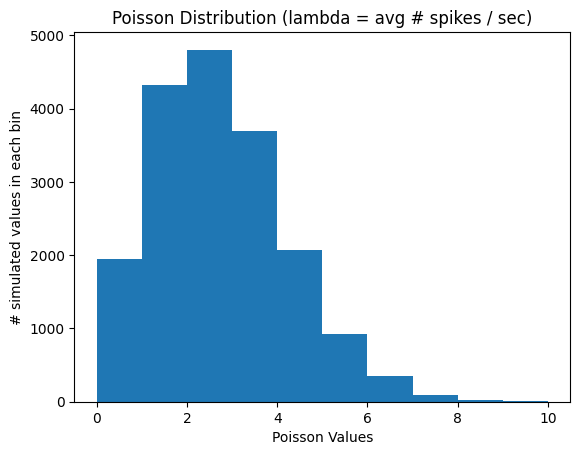

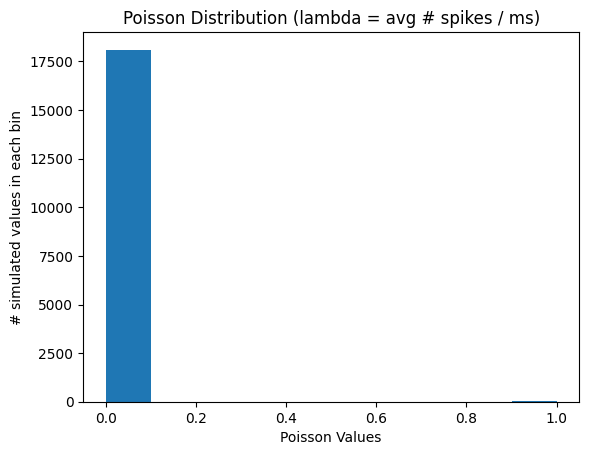

In [46]:
plt.figure(1)
plt.hist(isi_ms, bins = 100)
plt.xlabel("ISI (ms)")
plt.ylabel("# ISI in each bin")
plt.title("ISI Distribution for Unit 1")

plt.figure(2)
plt.hist(poissonSim)
plt.xlabel("Poisson Values")
plt.ylabel("# simulated values in each bin")
plt.title("Poisson Distribution (lambda = avg # spikes / sec)")

In [53]:
max(unitSpikeTimes_whole[0])

8114162

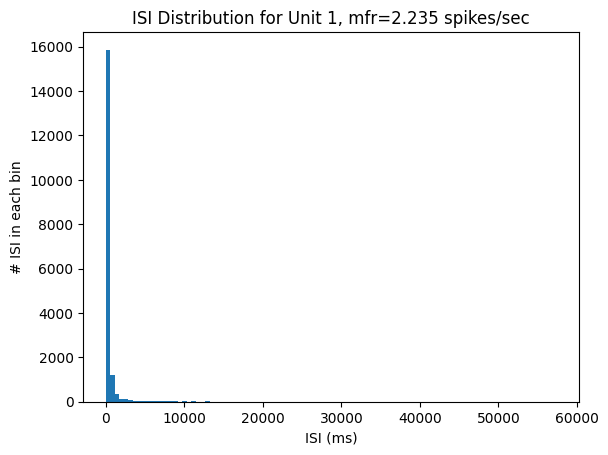

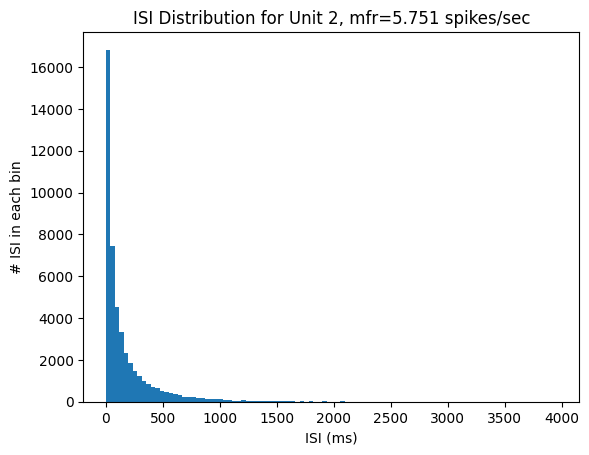

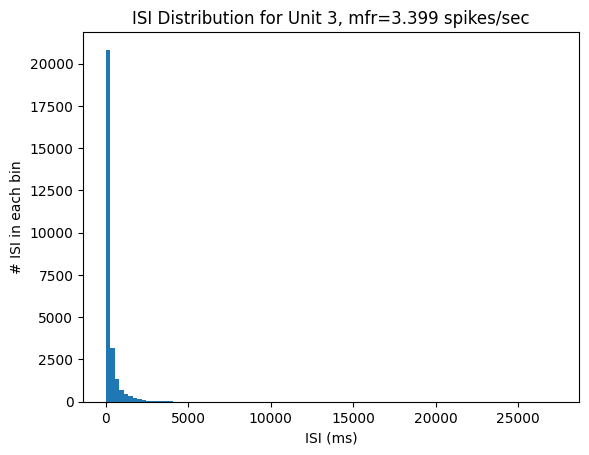

In [52]:
for i in range(3):
    mfr = sum(spikeTrains[i])/len(spikeTrains[i]) * 1000 # avg num of spikes per sec
    isi = np.diff(unitSpikeTimes_whole[i])
    
    poissonSim = np.random.poisson(mfr, (len(isi),))

    plt.figure(i) # gogobop
    plt.hist(isi, bins = 100)
    plt.xlabel("ISI (ms)")
    plt.ylabel("# ISI in each bin")
    plt.title(f"ISI Distribution for Unit {str(i+1)}, mfr={np.round(mfr,3)} spikes/sec")

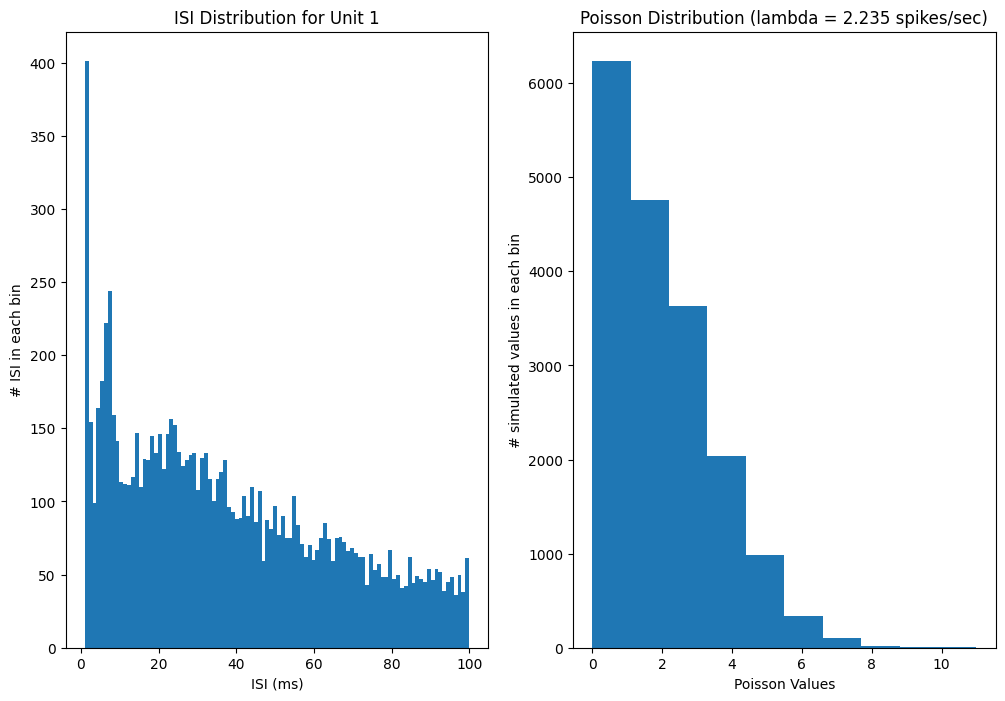

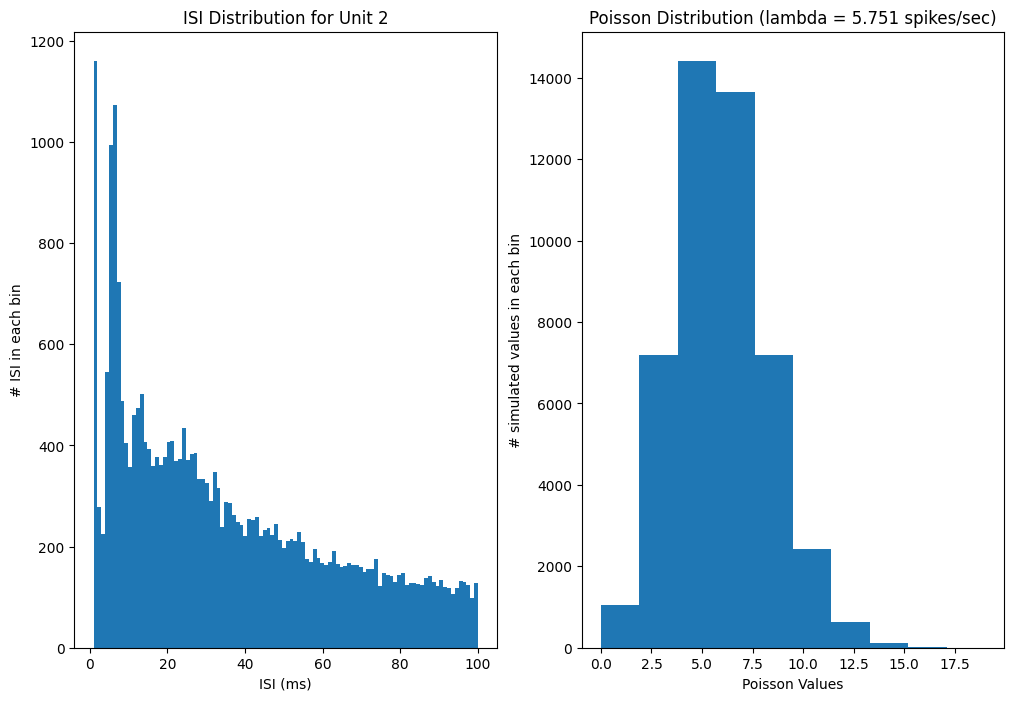

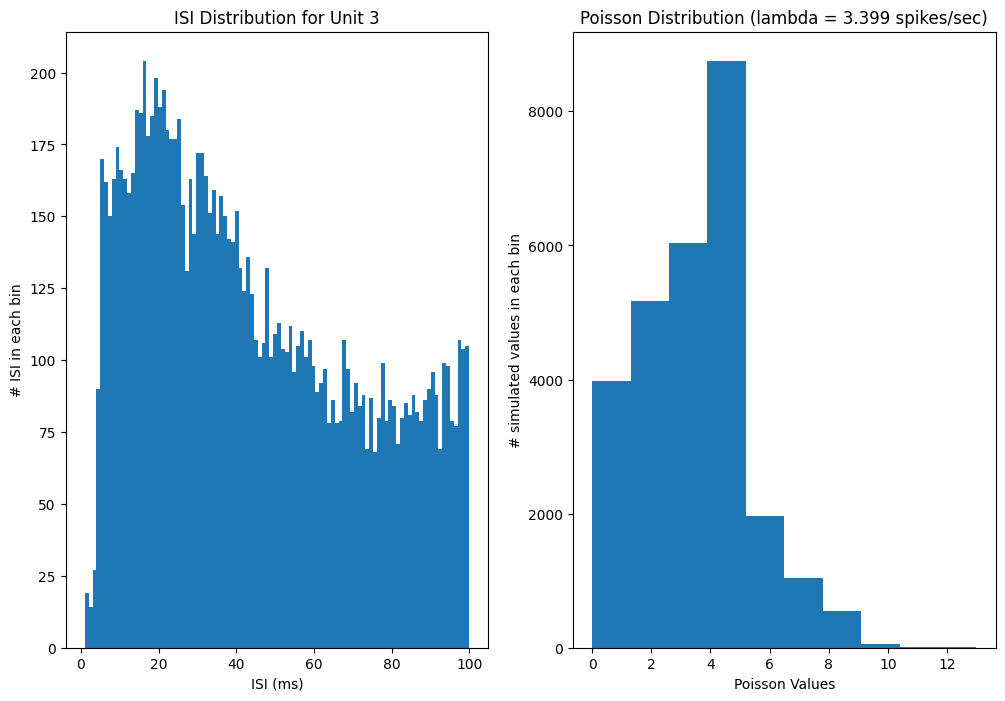

In [69]:
for i in range(3):
    mfr = sum(spikeTrains[i])/len(spikeTrains[i]) * 1000 # avg num of spikes per sec
    isi = np.diff(unitSpikeTimes_whole[i])
    isi_restr = [x for x in isi if x <=100]
    
    poissonSim = np.random.poisson(mfr, (len(isi),))

    plt.figure(i, figsize=(12, 8))

    plt.subplot(1, 2, 1) # gogobop
    plt.hist(isi_restr, bins = 100)
    plt.xlabel("ISI (ms)")
    plt.ylabel("# ISI in each bin")
    plt.title(f"ISI Distribution for Unit {str(i+1)}")

    plt.subplot(1, 2, 2) # gogobop
    plt.hist(poissonSim, bins = 10)
    plt.xlabel("Poisson Values")
    plt.ylabel("# simulated values in each bin")
    plt.title(f"Poisson Distribution (lambda = {np.round(mfr,3)} spikes/sec)")
    plt.savefig(f"ISIHUnit{str(i+1)}.png")

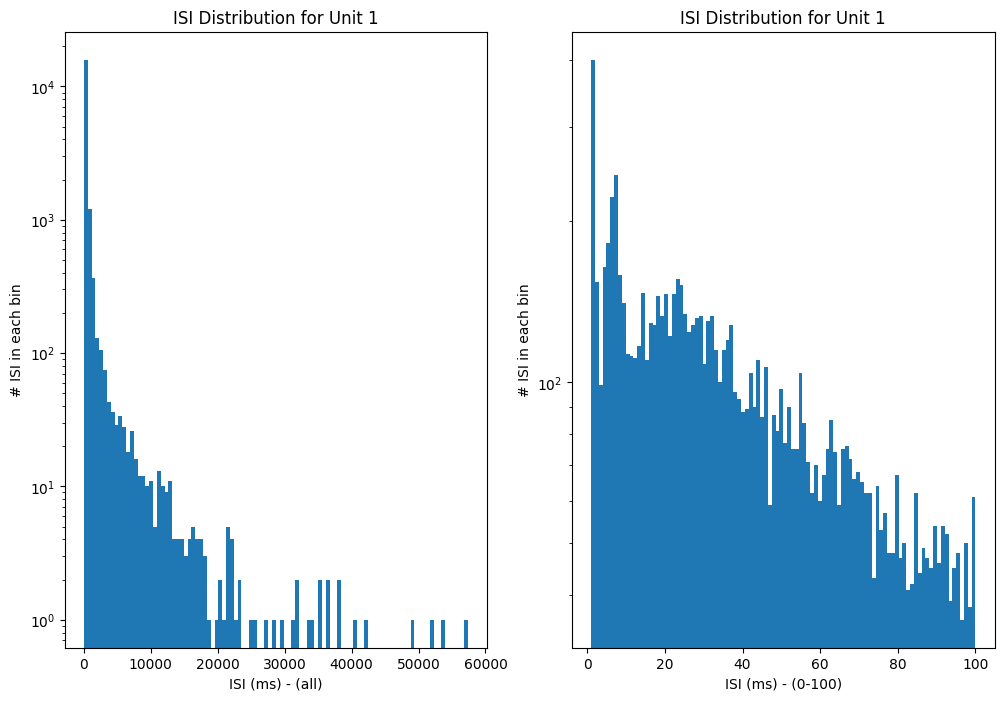

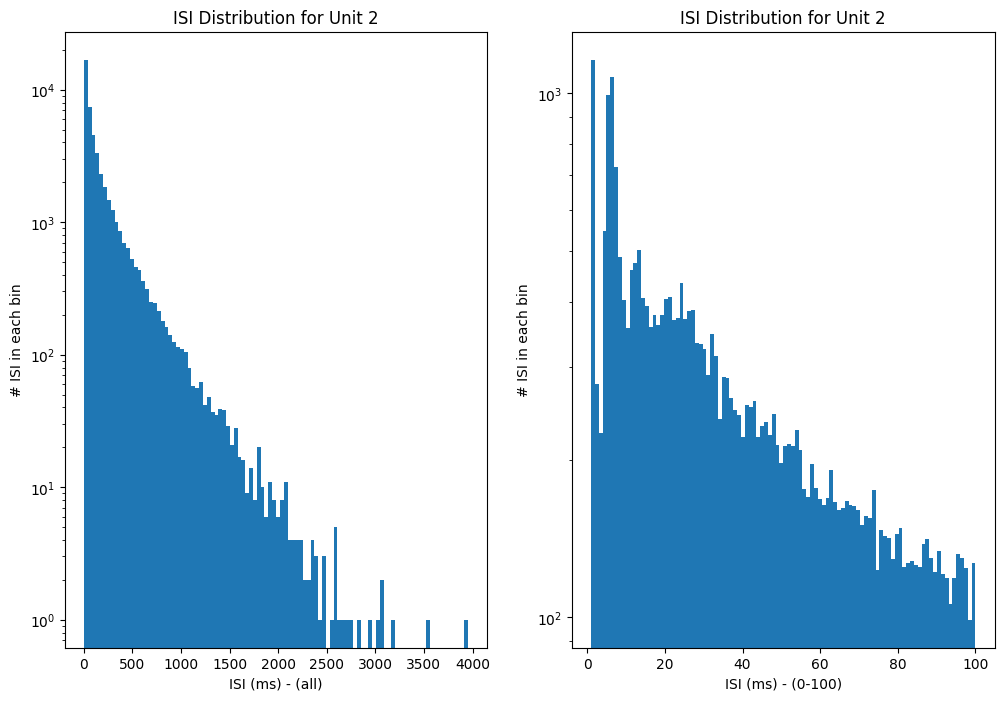

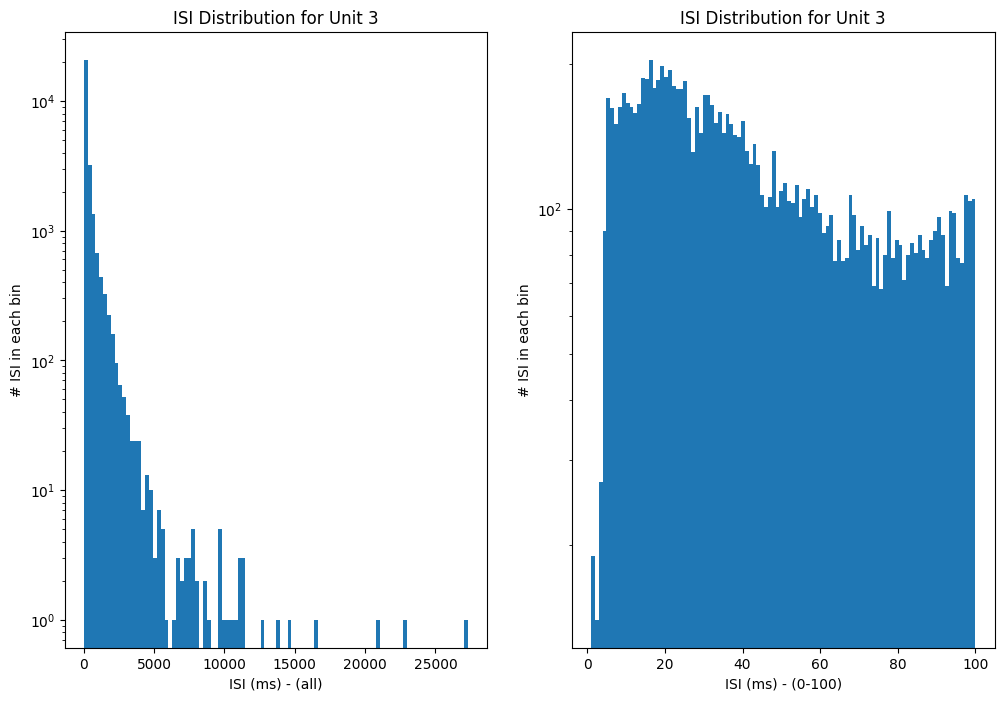

In [73]:
# Separately plot the ISIH using log-spaced y-axis binning so that the plot will look like a linear plot?
# (p=exp(-lambda*isi) => log(p) = -lambda*isi)

for i in range(3):
    isi = np.diff(unitSpikeTimes_whole[i])
    isi_restr = [x for x in isi if x <=100]

    plt.figure(i, figsize=(12, 8))

    plt.subplot(1, 2, 1)    
    plt.yscale("log") 
    plt.hist(isi, bins = 100)
    
    plt.xlabel("ISI (ms) - (all)")
    plt.ylabel("# ISI in each bin")
    plt.title(f"ISI Distribution for Unit {str(i+1)}")

    
    plt.subplot(1, 2, 2)    
    plt.yscale("log") 
    plt.hist(isi_restr, bins = 100)
    
    plt.xlabel("ISI (ms) - (0-100)")
    plt.ylabel("# ISI in each bin")
    plt.title(f"ISI Distribution for Unit {str(i+1)}")
    
    plt.savefig(f"ISIH-Unit0{str(i+1)}_ylog.png")